# **COSC 6377 Computer Networks - Final Project**

## Part 1: Video QoE Predictor for Internet Video Streaming using Machine Learning

*Mai Trinh*

University of Houston

In [ ]:
from scipy import io
import pandas as pd
import glob

import sys
import os
import numpy as np


from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import svm
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
# %matplotlib
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

## Data Generation


In [ ]:
import pickle

from google.colab import drive
drive.mount('/gdrive')  

Mounted at /gdrive


In [ ]:
# Input data files are uploaded to Google Drive and can be accessed from Colab
DATA_PATH = '/gdrive/My Drive/LIVE-NFLX-II-SubjectiveVideoQoEDatabase/Dataset_Information'

In [ ]:
# get data from .mat files
path = DATA_PATH + "/Mat_Files/*.mat"
df = pd.DataFrame()
for file in glob.glob(path):
   v = io.loadmat(file)
   dict_df = pd.DataFrame.from_dict(v, orient='index')
   dict_df = dict_df.transpose()
   df = df.append(dict_df)
  
df = df.reset_index()

In [ ]:
df.head(5)

,index,__header__,__version__,__globals__,content_name,STRRED,N_playback_frames,VMAF,SSIM,buffer_evolution_sec,height,playback_duration_sec,playout_bitrate,continuous_zscored_mos,scene_cuts_detected,PSNR,MSSIM,per_segment_encoding_QP,rebuffer_duration_sec,video_duration_sec,width,per_segment_encoding_height,selected_streams,distorted_mp4_video,adaptation_algorithm,rebuffer_number,content_spatial_information,content_temporal_information,frame_rate,per_segment_encoding_width,cropping_parameters,throughput_trace_name,content_name_acronym,scene_cuts,N_rebuffer_frames,is_rebuffered_bool,throughput_trace_kbps,reference_yuv_video,N_total_frames,retrospective_zscored_mos
0,0,"b'MATLAB 5.0 MAT-file Platform: posix, Created...",1.0,[],[MeridianConversation],"[[20.67487629636, 20.67487629636, 19.739728692...",[[799]],"[[76.61021248860051, 77.03156365612931, 76.862...","[[0.987276, 0.987188, 0.987227, 0.987218, 0.98...","[[1.1333333333333333, 2.1081390575141046, 3.63...",[[1080]],[[26.633333333333333]],"[[145.44, 145.44, 145.44, 145.44, 145.44, 145....","[[0.19150631585507147, 0.19150631585507147, 0....","[[68, 285, 594, 750]]","[[40.551733, 40.362194, 40.479569, 40.332024, ...","[[0.984217, 0.983953, 0.984145, 0.983945, 0.98...","[[31, 28, 31, 31, 31, 19, 25, 22, 22, 22, 19, ...",[[0.0]],[[26.633333333333333]],[[1920]],"[[720, 720, 720, 720, 720, 1080, 1080, 1080, 1...","[[0, 0, 0, 0, 3, 2, 3, 3, 3, 4, 1, 3, 3, 4, 0]]",[MeridianConversation_HuangBufferBasedAdaptor_...,[HuangBufferBasedAdaptor],[[0]],[[36.516496571081376]],[[3.111321647896646]],[[30.0]],"[[1280, 1280, 1280, 1280, 1280, 1920, 1920, 19...",[1920:1080:0:0],[Ferry_nesoddtangen_oslo],[MC],"[[34, 68, 123, 178, 233, 285, 337, 389, 441, 4...",[[0]],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1158.914847590954, 1407.1688311688313, 1239....",[MeridianConversation.yuv],[[799]],[[1.2723568714322702]]
1,0,"b'MATLAB 5.0 MAT-file Platform: posix, Created...",1.0,[],[MeridianConversation],"[[20.67487629636, 20.67487629636, 19.739728692...",[[799]],"[[76.61021248860051, 77.03156365612931, 76.862...","[[0.987276, 0.987188, 0.987227, 0.987218, 0.98...","[[1.1333333333333333, 1.1333333333333333, 1.83...",[[1080]],[[26.633333333333333]],"[[145.44, 145.44, 145.44, 145.44, 145.44, 145....","[[0.3250899381772339, 0.3250899381772339, 0.32...","[[68, 285, 594, 750]]","[[40.551733, 40.362194, 40.479569, 40.332024, ...","[[0.984217, 0.983953, 0.984145, 0.983945, 0.98...","[[31, 28, 31, 31, 31, 31, 34, 34, 31, 34, 31, ...",[[1.0666666666666667]],[[27.7]],[[1920]],"[[720, 1080, 720, 720, 720, 720, 1080, 1080, 7...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[MeridianConversation_SimpleThroughputBasedAda...,[SimpleThroughputBasedAdaptor],[[3]],[[36.516496571081376]],[[3.111321647896646]],[[30.0]],"[[1280, 1920, 1280, 1280, 1280, 1280, 1920, 19...",[1920:1080:0:0],[Tram_ljabru_jernbanetorget],[MC],"[[34, 68, 123, 178, 233, 285, 337, 389, 441, 4...",[[32]],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[325.163137254902, 182.350099009901, 256.9180...",[MeridianConversation.yuv],[[831]],[[-0.39726943637474715]]
2,0,"b'MATLAB 5.0 MAT-file Platform: posix, Created...",1.0,[],[MeridianConversation],"[[20.67487629636, 20.67487629636, 19.739728692...",[[799]],"[[76.61021248860051, 77.03156365612931, 76.862...","[[0.987276, 0.987188, 0.987227, 0.987218, 0.98...","[[1.1333333333333333, 2.1081390575141046, 3.36...",[[1080]],[[26.633333333333333]],"[[145.44, 145.44, 145.44, 145.44, 145.44, 145....","[[0.12432982760159361, 0.12432982760159361, 0....","[[68, 285, 594, 750]]","[[40.551733, 40.362194, 40.479569, 40.332024, ...","[[0.984217, 0.983953, 0.984145, 0.983945, 0.98...","[[31, 28, 31, 22, 25, 19, 22, 22, 19, 28, 19, ...",[[0.0]],[[26.633333333333333]],[[1920]],"[[720, 720, 1080, 1080, 1080, 1080, 1080, 1080...","[[0, 1, 3, 2, 3, 3, 3, 4, 1, 4, 2, 4, 0, 4, 3]]",[MeridianConversation_VMAFViterbiQualityBasedA...,[VMAFViterbiQualityBasedAdaptor],[[0]],[[36.516496571081376]],[[3.1113216478

## Data Cleaning and Preprocessing

Preprocessing the data into a format that is suitable for exploratory analysis and modeling.
* Remove unnecessary data such as filename, header, etc. 
* Drop missing values, outliers
* Seperate discrete features and continuous features.

In [ ]:
discrete_labels = ['adaptation_algorithm', 'retrospective_zscored_mos', 
                      'width','height', 'frame_rate',
                      'content_spatial_information', 'content_temporal_information',
                   'N_total_frames', 'N_playback_frames','N_rebuffer_frames',
                   'video_duration_sec','playback_duration_sec','rebuffer_duration_sec', 'rebuffer_number',]

continuous_labels = ['continuous_zscored_mos', 'STRRED', 'VMAF', 'SSIM', 'PSNR', 'MSSIM',
                     'per_segment_encoding_QP', 'per_segment_encoding_height','per_segment_encoding_width',
                     'selected_streams', 'buffer_evolution_sec','is_rebuffered_bool',
                   'playout_bitrate', 'throughput_trace_kbps']

# Separate categorical and continuous features
discrete_df = df[discrete_labels]
continuous_df = df[continuous_labels]

In [ ]:
def expand(row, feature):
  flat_list = [item for sublist in row[feature] for item in sublist]
  return flat_list

In [ ]:
for feature in discrete_labels:
  if(feature != 'adaptation_algorithm' and feature != 'throughput_trace_name'):
    discrete_df[feature] = discrete_df.apply(lambda row: expand(row, feature), axis=1)
  discrete_df[feature] = discrete_df[feature].apply(lambda x: x[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
discrete_df.head(5)

,adaptation_algorithm,retrospective_zscored_mos,width,height,frame_rate,content_spatial_information,content_temporal_information,N_total_frames,N_playback_frames,N_rebuffer_frames,video_duration_sec,playback_duration_sec,rebuffer_duration_sec,rebuffer_number
0,HuangBufferBasedAdaptor,1.272357,1920,1080,30.0,36.516497,3.111322,799,799,0,26.633333,26.633333,0.000000,0
1,SimpleThroughputBasedAdaptor,-0.397269,1920,1080,30.0,36.516497,3.111322,831,799,32,27.700000,26.633333,1.066667,3
2,VMAFViterbiQualityBasedAdaptor,1.255631,1920,1080,30.0,36.516497,3.111322,799,799,0,26.633333,26.633333,0.000000,0
3,OracleVMAFViterbiQualityBasedAdaptor,-0.203774,1920,1080,30.0,36.516497,3.111322,953,799,154,31.766667,26.633333,5.133333,3
4,VMAFViterbiQualityBasedAdaptor,-0.229013,1920,1080,30.0,36.516497,3.111322,799,799,0,26.633333,26.633333,0.000000,0


In [ ]:
for feature in continuous_labels:
  # continuous_df[feature] = continuous_df.apply(lambda row: expand(row, feature), axis=1)
  continuous_df[feature] = continuous_df[feature].apply(lambda x: x[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
continuous_df.head(5)

,continuous_zscored_mos,STRRED,VMAF,SSIM,PSNR,MSSIM,per_segment_encoding_QP,per_segment_encoding_height,per_segment_encoding_width,selected_streams,buffer_evolution_sec,is_rebuffered_bool,playout_bitrate,throughput_trace_kbps
0,"[0.19150631585507147, 0.19150631585507147, 0.1...","[20.67487629636, 20.67487629636, 19.739728692,...","[76.61021248860051, 77.03156365612931, 76.8629...","[0.987276, 0.987188, 0.987227, 0.987218, 0.987...","[40.551733, 40.362194, 40.479569, 40.332024, 4...","[0.984217, 0.983953, 0.984145, 0.983945, 0.984...","[31, 28, 31, 31, 31, 19, 25, 22, 22, 22, 19, 2...","[720, 720, 720, 720, 720, 1080, 1080, 1080, 10...","[1280, 1280, 1280, 1280, 1280, 1920, 1920, 192...","[0, 0, 0, 0, 3, 2, 3, 3, 3, 4, 1, 3, 3, 4, 0]","[1.1333333333333333, 2.1081390575141046, 3.639...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[145.44, 145.44, 145.44, 145.44, 145.44, 145.4...","[1158.914847590954, 1407.1688311688313, 1239.9..."
1,"[0.3250899381772339, 0.3250899381772339, 0.325...","[20.67487629636, 20.67487629636, 19.739728692,...","[76.61021248860051, 77.03156365612931, 76.8629...","[0.987276, 0.987188, 0.987227, 0.987218, 0.987...","[40.551733, 40.362194, 40.479569, 40.332024, 4...","[0.984217, 0.983953, 0.984145, 0.983945, 0.984...","[31, 28, 31, 31, 31, 31, 34, 34, 31, 34, 31, 3...","[720, 1080, 720, 720, 720, 720, 1080, 1080, 72...","[1280, 1920, 1280, 1280, 1280, 1280, 1920, 192...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1.1333333333333333, 1.1333333333333333, 1.833...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[145.44, 145.44, 145.44, 145.44, 145.44, 145.4...","[325.163137254902, 182.350099009901, 256.91807..."
2,"[0.12432982760159361, 0.12432982760159361, 0.1...","[20.67487629636, 20.67487629636, 19.739728692,...","[76.61021248860051, 77.03156365612931, 76.8629...","[0.987276, 0.987188, 0.987227, 0.987218, 0.987...","[40.551733, 40.362194, 40.479569, 40.332024, 4...","[0.984217, 0.983953, 0.984145, 0.983945, 0.984...","[31, 28, 31, 22, 25, 19, 22, 22, 19, 28, 19, 2...","[720, 720, 1080, 1080, 1080, 1080, 1080, 1080,...","[1280, 1280, 1920, 1920, 1920, 1920, 1920, 192...","[0, 1, 3, 2, 3, 3, 3, 4, 1, 4, 2, 4, 0, 4, 3]","[1.1333333333333333, 2.1081390575141046, 3.368...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[145.44, 145.44, 145.44, 145.44, 145.44, 145.4...","[1158.914847590954, 1407.1688311688313, 1239.9..."
3,"[0.13444663300223456, 0.13444663300223456, 0.1...","[20.67487629636, 20.67487629636, 19.739728692,...","[76.61021248860051, 77.03156365612931, 76.8629...","[0.987276, 0.987188, 0.987227, 0.987218, 0.987...","[40.551733, 40.362194, 40.479569, 40.332024, 4...","[0.984217, 0.983953, 0.984145, 0.983945, 0.984...","[31, 28, 31, 31, 31, 31, 31, 31, 28, 28, 28, 3...","[720, 720, 720, 720, 720, 720, 1080, 1080, 108...","[1280, 1280, 1280, 1280, 1280, 1280, 1920, 192...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2]","[1.1333333333333333, 1.6812640575798472, 1.833...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[145.44, 145.44, 145.44, 145.44, 145.44, 145.4...","[313.83529411764704, 44.4692644300896, 168.48,..."
4,"[0.14359280786001125, 0.14359280786001125, 0.1...","[20.67487629636, 20.67487629636, 19.739728692,...","[76.61021248860051, 77.03156365612931, 76.8629...","[0.987276, 0.987188, 0.987227, 0.987218, 0.987...","[40.551733, 40.362194, 40.479569, 40.332024, 4...","[0.984217, 0.983953, 0.984145, 0.983945, 0.984...","[31, 28, 31, 31, 31, 31, 34, 34, 31, 34, 31, 3...","[720, 720, 720, 720, 720, 720, 1080, 1080, 720...","[1280, 1280, 1280, 1280, 1280, 1280, 1920, 192...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[1.1333333333333333, 1.7016579711822883, 1.996...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[145.44, 145.44, 145.44, 145.44, 145.44, 145.4...","[325.163137254902, 182.350099009901, 256.91807..."


In [ ]:
discrete_df.isnull().sum()

adaptation_algorithm            0
retrospective_zscored_mos       0
width                           0
height                          0
frame_rate                      0
content_spatial_information     0
content_temporal_information    0
N_total_frames                  0
N_playback_frames               0
N_rebuffer_frames               0
video_duration_sec              0
playback_duration_sec           0
rebuffer_duration_sec           0
rebuffer_number                 0
dtype: int64

## Exploratory Analysis

In video streaming, human subjective scores serve an important role in optimizing QoE. Thus, in this section, we will analysize the relationship between several objective features in video quality and the collected retrospective and continuous-time subjective scores.

### Analysis using Continuous Scores

Average continuous_zscored_mos, bitrate and video quality assessment (VMAF) accross frame. 
* continuous_zscored_mos: the continuous subjective scores (for every frame in the video sequence), after performing z-scoring per subject and then averaging over all subjects (that watched this particular video sequence)
* playout_bitrate: the bitrate for each frames belonging to a segment. If it is a rebuffering event, the bitrate is set to 0 for that frame
* Video quality assessment:
  * PSNR: the per-frame PSNR scores calculated between the reference and distorted videos, after removing black bars and rebuffered frames

  * SSIM: the per-frame SSIM scores calculated between the reference and distorted videos, after removing black bars and rebuffered frames

  * MSSIM: the per-frame MS-SSIM scores calculated between the reference and distorted videos, after removing black bars and rebuffered frames

  * STRRED: the per-frame ST-RRED scores calculated between the reference and distorted videos, after removing black bars and rebuffered frames

  * VMAF: the per-frame VMAF scores calculated between the reference and distorted videos, after removing black bars and rebuffered frames

In this project, I use VMAF as the video quality assessment (VQA) measurement. The choice of VMAF is not restrictive, and other video quality measurements such as PSNR or SSIM can also be used.
* Video Multi-method Assessment Fusion (VMAF)  is an objective full-reference video quality metric which is formulated explicitly by Netflix to estimate subjective video quality based on a reference and distorted video sequence.
* Read more about VMAF here: https://en.wikipedia.org/wiki/Video_Multimethod_Assessment_Fusion

In [ ]:
# https://stackoverflow.com/questions/10058227/calculating-mean-of-arrays-with-different-lengths

# Calculate the average of arrays with different lengths
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

In [ ]:
continuous_mos = np.array(continuous_df['continuous_zscored_mos'])
avg_mos = avgNestedLists(continuous_mos)

In [ ]:
vmaf = np.array(continuous_df['VMAF'])
avg_vmaf = avgNestedLists(vmaf)

In [ ]:
bitrate = np.array(continuous_df['playout_bitrate'])
avg_bitrate = avgNestedLists(bitrate)

In [ ]:
throughput = np.array(continuous_df['throughput_trace_kbps'])
avg_throughput = avgNestedLists(throughput)

Text(0.5, 0, 'frame')

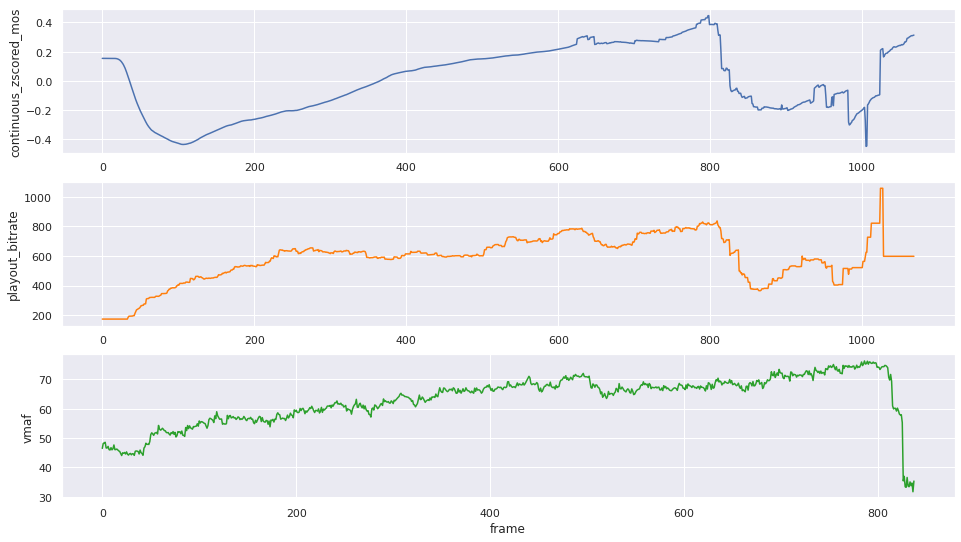

In [ ]:
# create a figure and axis
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,9))


ax1.plot(np.arange(0,len(avg_mos)),avg_mos)
ax1.set_ylabel('continuous_zscored_mos')
# ax1.set_xlabel('frame')


ax2.plot(np.arange(0,len(avg_bitrate)),avg_bitrate, 'tab:orange')
ax2.set_ylabel('playout_bitrate')
# ax2.set_xlabel('frame')


ax3.plot(np.arange(0,len(avg_vmaf)),avg_vmaf, 'tab:green')
# set a title and labels
# ax.set_title('Dataset')
ax3.set_ylabel('vmaf')
ax3.set_xlabel('frame')

# ax4.plot(np.arange(0,len(avg_throughput)),avg_throughput, 'tab:green')
# # set a title and labels
# # ax.set_title('Dataset')
# ax4.set_ylabel('throughput')
# ax4.set_xlabel('frame')

After 800 frames, QoE measurement (MOS) is decreasing since it corresponds to rebuffered frames, thus their count decreases over time. We also see a linear correlation between bitrate and the QoE measurement as well as the video quality assessment measurement (i.e. VMAF). While there might some outlier cases, we can generally say that video quality assessment (VMAF) and bitrate are important QoE factors.

In [ ]:
# scale the bitrate data to [-1,1] range
# NumPy provides numpy.interp for 1-dimensional linear interpolation. 
# map the minimum element of the array to −1 and the maximum to +1, and other elements linearly in-between.
avg_scaled_bitrate = np.interp(avg_bitrate, (min(avg_bitrate), max(avg_bitrate)), (-1, +1))

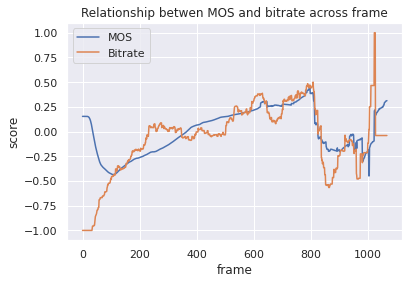

In [ ]:
# plotting the line 1 points 
plt.plot(np.arange(0,len(avg_mos)), avg_mos, label = "MOS")

# plotting the line 2 points 
plt.plot(np.arange(0,len(avg_bitrate)), avg_scaled_bitrate, label = "Bitrate")
plt.xlabel('frame')
# Set the y axis label of the current axis.
plt.ylabel('score')
# Set a title of the current axes.
plt.title('Relationship betwen MOS and bitrate across frame')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

I scaled the bitrate data into range [-1,1] to easily compare the relationship between human subjective score and the bitrate level. Again, we can easily see the general trend (although there are outlier cases).

### Analysis using Retrospective Scores

To identify the main QoE factors, I analysed the relationship betweem retrospective scores and the number and duration of rebuffering events.

In [ ]:
discrete_df.head(5)

,adaptation_algorithm,retrospective_zscored_mos,width,height,frame_rate,content_spatial_information,content_temporal_information,N_total_frames,N_playback_frames,N_rebuffer_frames,video_duration_sec,playback_duration_sec,rebuffer_duration_sec,rebuffer_number
0,HuangBufferBasedAdaptor,1.272357,1920,1080,30.0,36.516497,3.111322,799,799,0,26.633333,26.633333,0.000000,0
1,SimpleThroughputBasedAdaptor,-0.397269,1920,1080,30.0,36.516497,3.111322,831,799,32,27.700000,26.633333,1.066667,3
2,VMAFViterbiQualityBasedAdaptor,1.255631,1920,1080,30.0,36.516497,3.111322,799,799,0,26.633333,26.633333,0.000000,0
3,OracleVMAFViterbiQualityBasedAdaptor,-0.203774,1920,1080,30.0,36.516497,3.111322,953,799,154,31.766667,26.633333,5.133333,3
4,VMAFViterbiQualityBasedAdaptor,-0.229013,1920,1080,30.0,36.516497,3.111322,799,799,0,26.633333,26.633333,0.000000,0


Text(0.5, 0, 'Number of rebuffer frames')

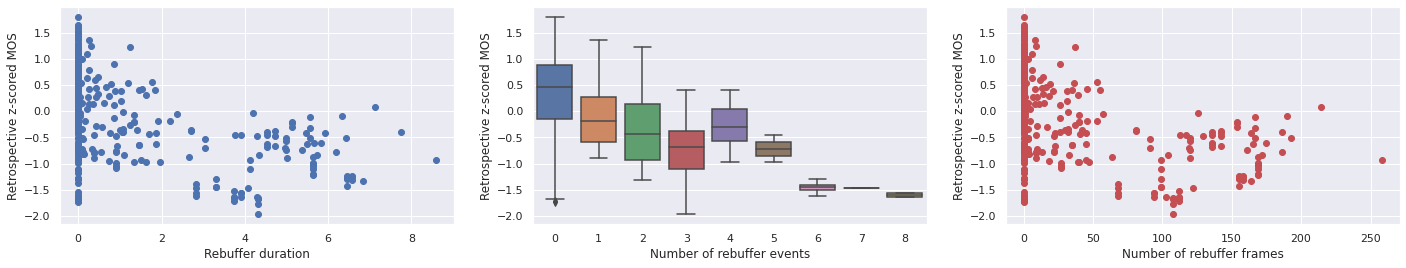

In [ ]:
# create a figure and axis
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,4))

ax1.scatter(discrete_df['rebuffer_duration_sec'],discrete_df['retrospective_zscored_mos'])

# set a title and labels
# ax.set_title('Dataset')
ax1.set_ylabel('Retrospective z-scored MOS')
ax1.set_xlabel('Rebuffer duration')

sns.boxplot(x='rebuffer_number', y='retrospective_zscored_mos', data=discrete_df, ax=ax2).set(xlabel='Number of rebuffer events', ylabel='Retrospective z-scored MOS')

ax3.scatter(discrete_df['N_rebuffer_frames'],discrete_df['retrospective_zscored_mos'], color='r')
ax3.set_ylabel('Retrospective z-scored MOS')
ax3.set_xlabel('Number of rebuffer frames')

We can see that QoE scores are effected by the rebuffering occurence and duration. A longer rebuffering time lowers QoE. However, as you can see in the second figure, the poins with 3,4,and 5 rebuffering events are not in decreasing MOS order, thus it means that larger rebuffering occurence does not necessarily imply larger rebuffer duration. Thus, the changes in QoE is determined by the combined factor of rebuffer duration and rebuffer occurences. That is, longer rebuffer duration and large rebuffer events caused the decreased in QoE.

In [ ]:
# sns.boxplot(x='rebuffer_number', y='retrospective_zscored_mos', data=discrete_df)

Text(0.5, 0, 'VMAF')

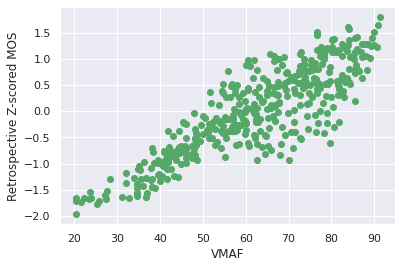

In [ ]:
# create a figure and axis
fig, ax = plt.subplots()

x = continuous_df['VMAF'].apply(np.average)
ax.scatter(x, discrete_df['retrospective_zscored_mos'], color='g')

# set a title and labels
# ax.set_title('Dataset')
ax.set_ylabel('Retrospective Z-scored MOS')
ax.set_xlabel('VMAF')


In this figure, I averaged VMAF score of each video sequence and compare it against retrospective MOS. This figured again show that there is a linear relationship between human subjective score and VMAF. Thus, we will use VMAF as the system-factor for video quality in our model, since this is something we can calculate, rather than acquiring human subjective score for every video streaming. 

## QoE predictor model

### Features Selection 
Given the dataset, I performed different analysis and determined the 3 aspects that affect the QoE in live video streaming:

* Frame video quality: VMAF can be measured using using *libvmaf* developed by Netflix. More details at https://github.com/Netflix/vmaf

* Rebuffering: QoE is greatly influenced by the occurence of rebuffering event in the video sequence.

* Bitrate: the higher the bitrate, the higher the QoE

Note that this is limited to this particular dataset, LIVE-NFLX-II Subjective Video QoE Database. If given the option to capture the real network traffic while streaming video, there are other factors that can contribute to QoE optimization such as network throughput for each frame, latency, etc.

Due to the nature of the problem, i.e. we are trying to predict user QoE of video streaming based on system-level factor, thus a continuous-based model is necessary. More this reason, I only used the continuous features that were available in the dataset. To predict continuous-time QoE, I proposed a Recurrent Neural Network (RNN) to achieve such task. More specifically, I used LSTM (Long short-term memory) network for this model.

Each video in the dataset is considered a dataset, and performed training-validation-test split as 70-10-20 according. That is 420 test evaluations that the model has to performed. That means the model is trained and test on the sets of video that do not have same content or parameters and metrics. By doing this, we are ensuring that the the trained model perform a fair evaluation.

Resources:
* Tutorial 1: https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
* Tutorial 2: https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
* N. Eswara et al., "Streaming Video QoE Modeling and Prediction: A Long Short-Term Memory Approach," in IEEE Transactions on Circuits and Systems for Video Technology, vol. 30, no. 3, pp. 661-673, March 2020, doi: 10.1109/TCSVT.2019.2895223.

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Activation
from keras.layers import TimeDistributed
from keras.optimizers import Adam

### Train-test split

In [ ]:
# 80-20 split for train set and test set respectively
def split_data(dataset):
  features = ['VMAF', 'is_rebuffered_bool', 'playout_bitrate']
  label = ['continuous_zscored_mos']

  vmaf = dataset['VMAF']
  rebufferd = dataset['is_rebuffered_bool']
  bitrate = dataset['playout_bitrate']
  mos = dataset['continuous_zscored_mos']

  # Dataset information
  no_videos = len(dataset['continuous_zscored_mos'])
  train_len = int(no_videos * 0.7)
  test_len = int(no_videos * 0.2)
  val_len = int(no_videos * 0.1)

  # df = dataset.sample(frac=1).reset_index(drop=True)

  #Training set
  vmaf_df = vmaf[:train_len]
  rebuffered_df= rebufferd[:train_len]
  bitrate_df = bitrate[:train_len]
  X_train = np.vstack((vmaf_df, rebuffered_df, bitrate_df)).T
  y_train = mos[:train_len]

  #Validation set
  vmaf_df = vmaf[:val_len]
  rebuffered_df= rebufferd[:val_len]
  bitrate_df = bitrate[:val_len]
  X_val = np.vstack((vmaf_df, rebuffered_df, bitrate_df)).T
  y_val = mos[:val_len]

  #Test set
  vmaf_df = vmaf[:test_len]
  rebuffered_df= rebufferd[:test_len]
  bitrate_df = bitrate[:test_len]
  X_test = np.vstack((vmaf_df, rebuffered_df, bitrate_df)).T
  y_test = mos[:test_len]

  return X_train, y_train, X_test, y_test, X_val, y_val

### Recurrent Neural Network Model

In [ ]:
# Build the neural network
class RNN:
  def __init__(self, batch_size, timesteps, features_size, dropout_probability):
    self.learning_rate = 0.001
    self.model = Sequential()
    self.model.add(LSTM(50, stateful = True, batch_input_shape=(batch_size, 1, features_size), return_sequences = True))
    self.model.add(LSTM(50, return_sequences = True, stateful = True))
    self.model.add(Dropout(dropout_probability))
    self.model.add(Dense(1, activation='relu'))
    self.model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # self.model.summary()
  
  def train(self, X_train, y_train, X_val, y_val, batch_size, epochs):
    print("Training...")

    for epoch in range(epochs):
      print("Epoch {0}/{1}".format(epoch, epochs))

      training_losses = []
      testing_losses = []

      # Model training
      history = self.model.fit(X_train, y_train,validation_data = (X_val,y_val), epochs=1, batch_size=batch_size, verbose=0)
      training_loss = history.history['loss']
      val_loss = history.history['val_loss']
      accuracy = history.history['accuracy']

      # track the validation loss	
      if epoch <= 5:
        best_val_loss = val_loss
        best_epoch_no = epoch

        # save model weights
        self.model.save_weights(filepath='/gdrive/My Drive/VideoQoE/save_models/RNN_best_model_weights.h5',overwrite=True)

      else:
        # Track the validation loss:
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch_no = epoch

          # Save model 
          self.model.save_weights(filepath='/gdrive/My Drive/VideoQoE/save_models/RNN_best_model_weights.h5',overwrite=True)

          print("Best epoch", epoch)
          print("Best val loss", best_val_loss)
          # print("Accuracy", accuracy)

      # reset the LSTM states
      self.model.reset_states()
    
  def load_weights(self):
	  self.model.load_weights(filepath='/gdrive/My Drive/VideoQoE/save_models/RNN_best_model_weights.h5')
	  # os.remove('/gdrive/My Drive/VideoQoE/save_models/RNN_best_model_weights.h5')
	
	  return self.model


### Train model

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

import scipy.io as sio
from scipy.io import loadmat, savemat
from scipy.stats.stats import pearsonr 
from scipy.stats import spearmanr

In [ ]:
for i in range(len(continuous_df)):
  row = continuous_df.iloc[0]
  #load train and test dataset
  X_train, y_train, X_test, y_test, X_val, y_val = split_data(row)

  # LSTM network initializations
  batch_size = 1 # batch size fixed to 1 as the LSTM network is stateful
  timesteps = 4
  features_size = 3 # number of input features
  dropout_probability = 0.2
  epochs = 50

  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  model = RNN(batch_size, timesteps, features_size, dropout_probability)
  model.train(X_train, y_train, X_val, y_val, batch_size, epochs)
  model = model.load_weights()

  # prediction using the trained model
  pred_QoE = model.predict(X_test,batch_size=1)
  pred_QoE = np.reshape(pred_QoE,(-1,))

  test_video_filename = '/gdrive/My Drive/VideoQoE/pred_QoE_matfiles/video_'+str(i)+'.mat'
  
  # save the predicted QoE
  sio.savemat(test_video_filename,{'pred_QoE': pred_QoE})
	
	# plot the predicted QoE and the actual QoE
  ax = plt.gca()
  plt.plot(pred_QoE,'r')
  plt.plot(y_test,'b')
  ax.legend(('Predicted QoE', 'Actual QoE'))
  plt.savefig('/gdrive/My Drive/VideoQoE/plots/'+'video_'+str(i)+'.png')
  plt.close()
  
  if i == 0:
    LCC_temp = pearsonr(pred_QoE,y_test)
    LCC_test = LCC_temp[0]
    SROCC_temp = spearmanr(pred_QoE,y_test)
    SROCC_test = SROCC_temp[0]
    RMSE_test = sqrt(mean_squared_error(pred_QoE,y_test))
  else:
    LCC_temp = pearsonr(pred_QoE,y_test)
    LCC_test = np.append(LCC_test,LCC_temp[0])
    SROCC_temp = spearmanr(pred_QoE,y_test)
    SROCC_test = np.append(SROCC_test,SROCC_temp[0])
    RMSE_test = np.append(RMSE_test,sqrt(mean_squared_error(pred_QoE,y_test)))
  
  # print the cumulative performance so far
  print('Test video:',i)
  print('LCC_test_mean:{0}'.format(np.nanmean(LCC_test)))
  print('SROCC_test_mean:{0}'.format(np.nanmean(SROCC_test)))
  print('RMSE_test_mean:{0}'.format(np.nanmean(RMSE_test)))

Streaming output truncated to the last 5000 lines.
Best epoch 35
Best val loss [0.008257366716861725]
Epoch 36/50
Best epoch 36
Best val loss [0.007939780130982399]
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Best epoch 48
Best val loss [0.007714890409260988]
Epoch 49/50
Test video: 3
LCC_test_mean:0.8119213918729951
SROCC_test_mean:0.8413942668715891
RMSE_test_mean:0.09338357641352123
Training...
Epoch 0/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Best epoch 6
Best val loss [0.01323919091373682]
Epoch 7/50
Best epoch 7
Best val loss [0.007424917537719011]
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Ep

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Streaming output truncated to the last 5000 lines.
Best val loss [0.011550432071089745]
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Best epoch 14
Best val loss [0.010594611056149006]
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Best epoch 31
Best val loss [0.009973746724426746]
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Best epoch 40
Best val loss [0.009389731101691723]
Epoch 41/50
Best epoch 41
Best val loss [0.008454535156488419]
Epoch 42/50
Epoch 43/50
Epoch 44/50
Best epoch 44
Best val loss [0.008093740791082382]
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Test video: 340
LCC_test_mean:0.8191657265584973
SROCC_test_mean:0.8697776691361535
RMSE_test_mean:0.10131515614599634
Training...
Epoch 0/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Ep

In [ ]:
print('####################### Test Performance #######################')

print('LCC_test_mean:', np.nanmean(LCC_test))
print('SROCC_test_mean:', np.nanmean(SROCC_test))
print('RMSE_test_mean:', np.nanmean(RMSE_test))

saving_filename = '/gdrive/My Drive/VideoQoE/LSTM_QoE_LIVE_NFLXII.mat'

sio.savemat(saving_filename,{
'LCC_test': LCC_test,
'SROCC_test': SROCC_test,
'RMSE_test': RMSE_test
})

####################### Test Performance #######################
LCC_test_mean: 0.8170055349803346
SROCC_test_mean: 0.8685719920880821
RMSE_test_mean: 0.1019708490148646


In [ ]:
model.summary()

Model: "sequential_419"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_838 (LSTM)              (1, 1, 50)                10800     
_________________________________________________________________
lstm_839 (LSTM)              (1, 1, 50)                20200     
_________________________________________________________________
dropout_419 (Dropout)        (1, 1, 50)                0         
_________________________________________________________________
dense_419 (Dense)            (1, 1, 1)                 51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________
